Author: Iker Lomas Javaloyes

Email: iker.lomas1@estudiant.uib.cat

Create date: 10-09-2024 23:35:22

Description: This Python script is designed to calculate the numerical FAQUAD (Fast Quantum Adiabatic) signal for a two-level system (TLS) and compare it with the analytical solution. In this script, we implement numerical methods to compute the FAQUAD signal and validate its accuracy against known analytical solutions for the TLS.

Kernel: Julia 1.10.3

Libraries:

In [1]:
using LinearAlgebra
using Plots
using HCubature
using NLsolve
using LaTeXStrings
using Printf
using SciPy
using PyCall
using JLD2

# Calculation

Initial and final conditions that we will use to calculate the FAQUAD signal for a two-level system (TLS):

In [2]:
delta0 = 0.15
deltaf = -delta0
Omega = 0.02

0.02

## Analytical solution

The original Hamiltonian is:
$$

H = \frac{1}{2}\begin{pmatrix} \delta(t) &\Omega \\ \Omega & -\delta(t)\end{pmatrix}

$$

The ODE to be solved is:
$$
\frac{\partial \delta(t)}{\partial t} = \pm c\left|\dfrac{[E_k(\delta) - E_i(\delta)]^2}{\langle \phi_i(\delta)|\partial_\delta H|\phi_k(\delta)\rangle}\right|
$$

We make the change of variable $s = t/T$, which $s$ being the so called normalized time with $s\in[0,1]$. Under this change of variable, the new ODE reads:
$$
\frac{\partial \delta(s)}{\partial s} = \pm \tilde{c}\left|\dfrac{[E_k(\delta) - E_i(\delta)]^2}{\langle \phi_i(\delta)|\partial_\delta H|\phi_k(\delta)\rangle}\right|,
$$
where we have defined the reescaled adiabatic constant $\tilde{c}\equiv cT$.

In [3]:
function compute_hamiltonian(delta, Omega)
    return 1/2*[delta Omega; Omega -delta]
end
function analytical_solution(t)
    return Omega * (-2 * c_tilde_analytical * t * Omega * sqrt(delta0 ^ 2 + Omega ^ 2) + delta0) / (sqrt(delta0 ^ 2 + Omega ^ 2) * sqrt(Omega * (Omega / (delta0 ^ 2 + Omega ^ 2) - 4 * c_tilde_analytical * t * (c_tilde_analytical * t * Omega - delta0 / (sqrt(delta0 ^ 2 + Omega ^ 2))))))
end

analytical_solution (generic function with 1 method)

In [4]:
c_tilde_analytical = abs((delta0 / sqrt(delta0 ^ 2 + Omega ^ 2) - deltaf / sqrt(deltaf ^ 2 + Omega ^ 2)) / (2 * Omega))

49.561395034131735

## Numerical solution

The Hamiltonian for this system, reads:
$$
\partial_\delta H = \frac{1}{2}\begin{pmatrix}
1 & 0 \\
0 & -1
\end{pmatrix}
$$

In [5]:
dim = 2  # Number of dimensions in the Hamiltonian
n_deltas = 2 ^ 8 + 1  # Due to the integration method, this must be in the form 2 ** k + 1

deltas = range(delta0, deltaf, n_deltas)

hypermatrix = zeros(n_deltas, dim, dim)
energies = zeros(n_deltas, dim)
states = zeros(n_deltas, dim, dim)
for i in 1:n_deltas
    hamiltonian = compute_hamiltonian(deltas[i], Omega)
    energies[i, :], states[i, :, :] = eigen(hamiltonian)
    hypermatrix[i, :, :] = hamiltonian
end

In [6]:
partial_Hamiltonian = 1/2*[1 0; 0 -1]

2×2 Matrix{Float64}:
 0.5   0.0
 0.0  -0.5

In this below cell, with the parameter factors I'm computing the values

$$
\tilde{c} \equiv \dfrac{\langle \phi_i(\delta)|\partial_\delta H|\phi_k(\delta)\rangle}{[E_k(\delta) - E_i(\delta)]^2}
$$
where $|\phi_i\rangle$ in the initial state.

In [7]:
initial_state = 0

function constant_c(x)
    H = compute_hamiltonian(x, Omega)
    eigenvalues, eigenfunctions = eigen(H)
    for i in range(0, dim)
        if i != initial_state
            return abs(dot(eigenfunctions[:,initial_state + 1], partial_Hamiltonian*eigenfunctions[:,i + 1])/(eigenvalues[initial_state + 1]-eigenvalues[i + 1])^2)
        end
    end
end

constant_c (generic function with 1 method)

In [8]:
C, error_c = hquadrature(constant_c, delta0, deltaf)

(-49.56139503413174, 4.717985846447448e-8)

In [9]:
c_tilde = abs(C)

49.56139503413174

In [10]:
println("The analytical solution is: $(@sprintf("%.5f", c_tilde_analytical))")
println("The numerical solution is: $(@sprintf("%.5f", c_tilde))")

The analytical solution is: 49.56140
The numerical solution is: 49.56140


In [11]:
factors = zeros(n_deltas, dim - 1)
counter = 1
for i in deltas
    factors[counter] = constant_c(i)
    counter += 1
end

In [12]:
deltas_array = zeros(size(factors))
deltas_array[:,1] = Array(deltas)

257-element Vector{Float64}:
  0.15
  0.148828125
  0.14765625
  0.146484375
  0.1453125
  0.144140625
  0.14296875
  0.141796875
  0.140625
  0.139453125
  ⋮
 -0.140625
 -0.141796875
 -0.14296875
 -0.144140625
 -0.1453125
 -0.146484375
 -0.14765625
 -0.148828125
 -0.15

In [13]:
sig = sign(deltas[2] - deltas[1])
equation = SciPy.interpolate.interp1d(deltas_array[:,1], 1 ./ sum(factors, dims=2)[:,1], kind="cubic", fill_value="extrapolate")  # Equation to solve
function model(y, _)
    return sig * c_tilde * equation(y)
end

ns = 10^4 # Number of sof points to solve the ODE
s = range(0, stop=1.0, length=ns)

0.0:0.00010001000100010001:1.0

Compute analytical and numerical solution for the TLS system

In [14]:
x_sol = SciPy.integrate.odeint(model, deltas[1], s) # Solve numerically the values of the parameter in terms of s
Analiytical_solution = analytical_solution.(s)

10000-element Vector{Float64}:
  0.15
  0.14831078188887387
  0.1466764125303681
  0.14509397642009703
  0.14356077060608147
  0.14207428516846307
  0.14063218584665862
  0.1392322985402192
  0.13787259544914898
  0.13655118265259072
  ⋮
 -0.13787259544915048
 -0.1392322985402194
 -0.1406321858466606
 -0.14207428516846365
 -0.14356077060608058
 -0.1450939764200981
 -0.1466764125303712
 -0.14831078188887364
 -0.15

## Results

Plot of the numerical and analytical solution for the TLS system

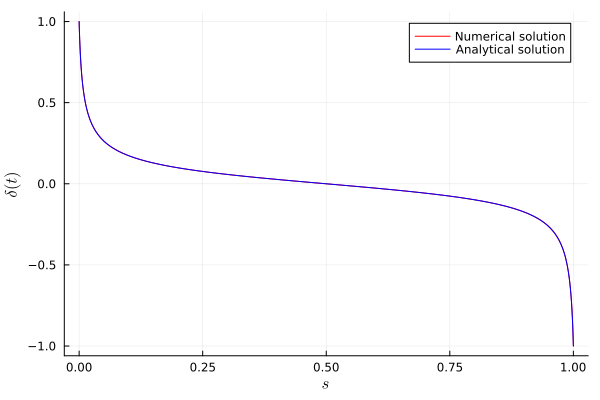

In [15]:
plot(s, x_sol/abs(x_sol[1]), label = "Numerical solution", color = "red")
plot!(s, Analiytical_solution/abs(Analiytical_solution[1]), label="Analytical solution", xlabel=L"s", ylabel=L"\delta(t)", color = "blue")

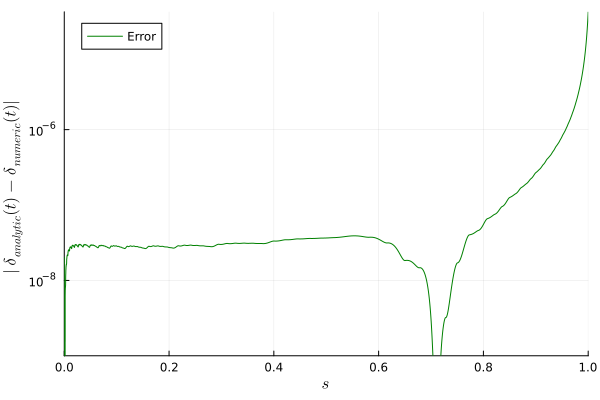

┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\ikerb\.julia\packages\Plots\ju9dp\src\utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\ikerb\.julia\packages\Plots\ju9dp\src\utils.jl:106
┌ Warning: Invalid negative or zero value 0.0 found at series index 1 for log10 based yscale
└ @ Plots C:\Users\ikerb\.julia\packages\Plots\ju9dp\src\utils.jl:106


In [16]:
err = abs.(x_sol[:,1] - analytical_solution.(s))
plot(s, err, yscale=:log10, label="Error", xlabel=L"s", ylabel=L"$|\delta_{analytic}(t) - \delta_{numeric}(t)|$", color = "green")
ylims!(1e-9, maximum(err))
xlims!(minimum(s), maximum(s))

### Save the TLS data

In [17]:
data = Dict("error" => err, "x_sol" => x_sol, "Solucion_analitica" => Analiytical_solution)
save("TLS_data.jld2", data)